In [ ]:
from datasets import load_dataset,  ClassLabel
import torch
import torchvision.transforms.v2 as T
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.IMAGENETTE)

In [ ]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [ ]:
imagenette = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y = Pipeline([parent_label, lbl_dict.get]),
                       splitter = GrandparentSplitter(valid_name='val'),
                       item_tfms = [RandomResizedCrop(64, min_scale=0.35)],
                       batch_tfms = [FlipItem(0.5),Normalize.from_stats(*imagenet_stats),RandomErasing()])

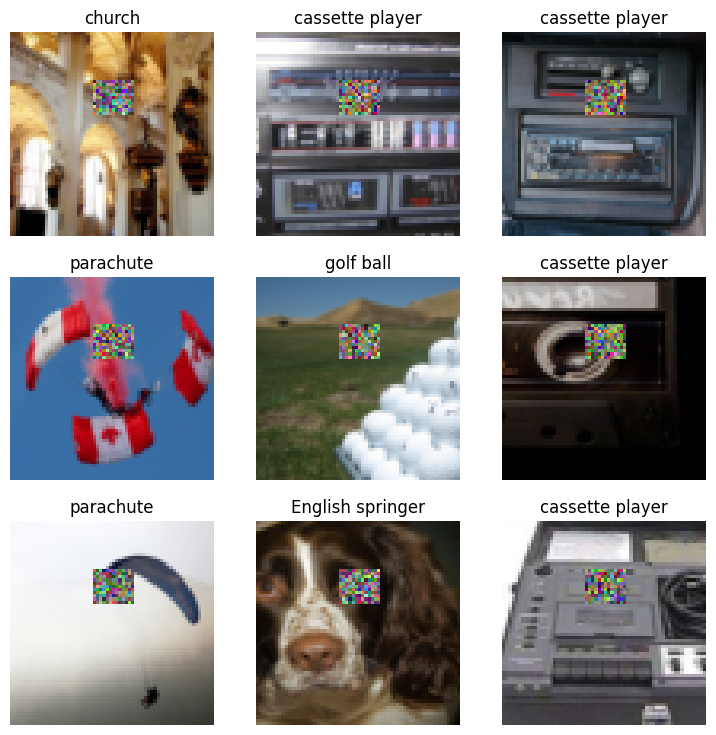

In [ ]:
dls = imagenette.dataloaders(path, bs = 32)
dls.show_batch()

In [ ]:
xb,yb = dls.one_batch()

## Diffusion definition

In [ ]:
def noisify_t(x,t, return_noise = False):
    alpha = torch.cos(t / 2 * math.pi)
    sigma = torch.sin(t / 2 * math.pi)
    n = torch.randn_like(x, device=x.device)
    z = x * alpha[:,None,None,None] + sigma[:,None,None,None] * n
    if return_noise: return z, n
    else: return z

In [ ]:
def noisify(x, return_noise = False):
    t = torch.rand(x.shape[0], device=x.device)
    return noisify_t(x,t, return_noise), t

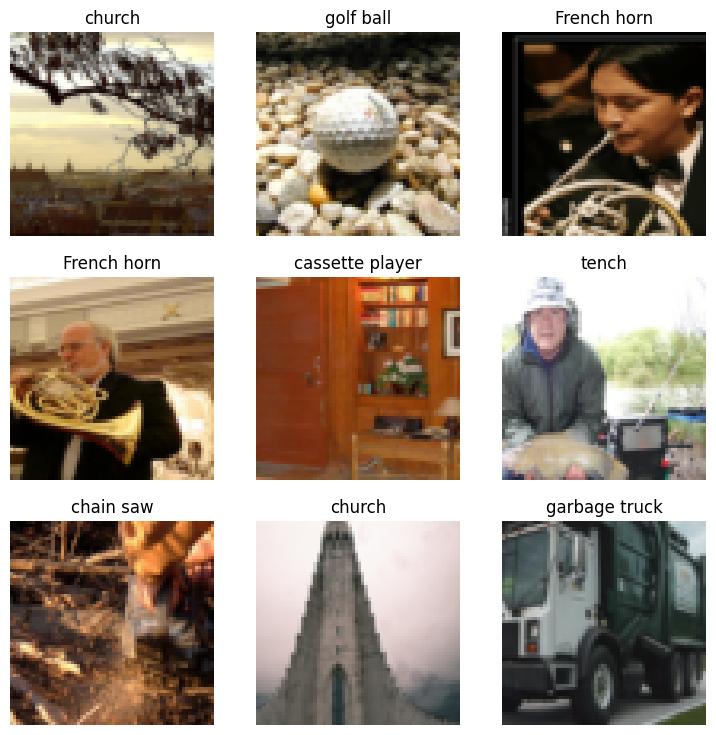

In [ ]:
dls.show_batch((xb,yb))

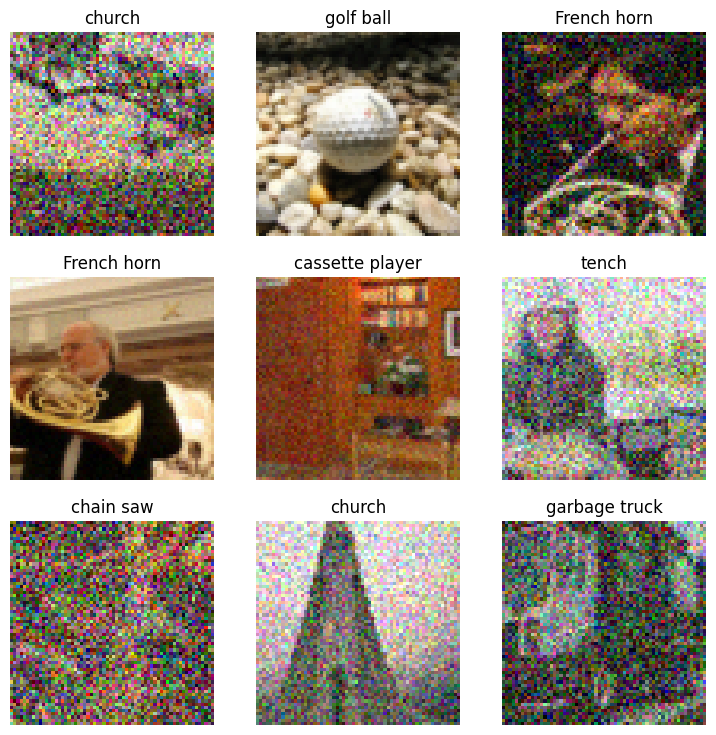

In [ ]:
set_seed(42)
dls.show_batch((noisify(xb)[0],yb))

In [ ]:
# config from simple diffusion
base_channels = 128
emb_channels = 1024
channel_multiplier = [1, 2, 4, 8, 8]
num_res_blocks = [3, 4, 4, 12, 4]
attn_resolutions = [8, 16]
num_heads = 4
dropout_from_resolution = 16
dropout = 0.1

# actual parameters
nfs = [base_channels * mult for mult in channel_multiplier]

In [ ]:
# config from matryoishka diffusion
resolutions = [64, 32, 16]
resolution_channels = [256, 512, 768]
num_res_blocks = [2, 2, 2]
num_attn_layers_per_block = [0, 1, 5]
num_heads = 8
schedule = 'cosine'
emb_channels = 1024
num_lm_attn_layers = 2
lm_feature_projected_channels = 1024

# actual parameters
nfs = resolution_channels

In [ ]:
from diffusers import DDIMScheduler
sched = DDIMScheduler(beta_schedule='squaredcos_cap_v2')

In [ ]:
# before_batch_cb
# def prepare(self, xb, yb):
#     (z,n), t = noisify(*xb, return_noise=True)
#     return (z, t), (n,)

def prepare(self, xb, yb):
    xb, yb = xb[0], yb[0]
    n = torch.randn_like(xb, device=xb.device)
    t = torch.randint(0, 1000, (len(xb),), device=xb.device)
    xb_t = sched.add_noise(xb, n, t)
    return (xb_t, t/1000.0, yb), (n,)

In [ ]:
from typing import Any
from diffusers import UNet2DModel

class UnetModel(UNet2DModel):
    def forward(self, x, t, c):
        return super().forward(x, t, c, return_dict=False)[0]
    def __getattr__(self, name: str) -> Any:
        if name == 'values': raise AttributeError
        return super().__getattr__(name)
    

model = UnetModel(norm_num_groups=16,
                  block_out_channels=(64,128,256,512),
                  num_class_embeds=len(lbl_dict))

In [ ]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in L(o.downsamplers): nn.init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [ ]:
init_ddpm(model)

In [ ]:
cbs = [MixedPrecision(amp_mode='fp16'),before_batch_cb(prepare),ShowGraphCallback(), GradientClip()]
learn = Learner(dls, model, cbs=cbs, loss_func=MSELossFlat())

SuggestedLRs(valley=9.120108734350652e-05)

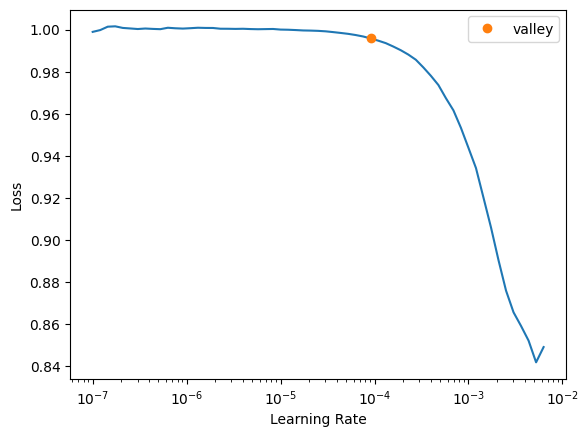

In [ ]:
learn.lr_find()

In [ ]:
import wandb
wandb.init(project="diffusion")
from fastai.callback.wandb import *

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: slakter. Use `wandb login --relogin` to force relogin


epoch,train_loss,valid_loss,time
0,0.215884,0.158907,03:04
1,0.150320,0.118132,03:03
2,0.147479,0.109043,03:03
3,0.130378,0.105730,03:03
4,0.130613,0.095250,03:03
5,0.127034,0.099631,03:03
6,0.126006,0.095706,03:03
7,0.121486,0.095935,03:03
8,0.122286,0.088536,03:04
9,0.118981,0.091047,03:02


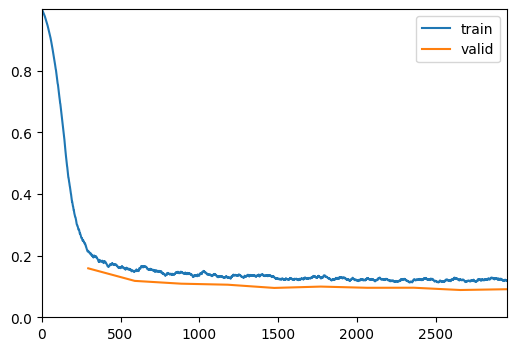

WandbCallback was not able to get prediction samples -> Match length mismatch


In [ ]:
astats = ActivationStats(with_hist=True,
                         modules = [model.down_blocks[0],model.down_blocks[1],model.up_blocks[0],model.up_blocks[1]],
                         every=50)
learn.fit_one_cycle(10, 1e-3, cbs=[WandbCallback(),astats])

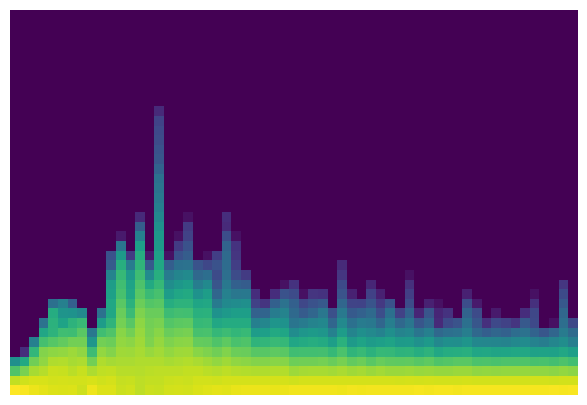

In [ ]:
astats.color_dim(3)

In [ ]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▂▁▁▂▂▃▂▂▁▂▁▂▁▁▁▁▁▁▁▁▂▂▂▁▁▂▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_samples_per_sec,▁██▇▇▇▇▆▄▇▇▇▇▇▇▇█▅▇▇▇█▇▆▆▂▇▇▇▇▇█▇▆▇▇▃▇██
valid_loss,█▄▃▃▂▂▂▂▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,10


In [ ]:
learn.save('hf-unet-64-init')

Path('models/hf-unet-64-init.pth')

In [ ]:
load_model('./models/hf_unet.pth', learn.model, None, with_opt=False)

## Sampling

In [ ]:
def diff_sampler(model, sz, sched, **kwargs):
    x_t = torch.randn(sz).cuda()
    preds = []
    preds.append(to_cpu(x_t))
    for t in progress_bar(sched.timesteps):
        with torch.no_grad(): noise = model(x_t, t.repeat(sz[0]).cuda()/1000.0,c=TensorCategory(1).cuda())
        x_t, = sched.step(noise, t, x_t, return_dict=False, eta=0.1)
        preds.append(to_cpu(x_t))
    return preds

In [ ]:
class DDIMScheduler:
    def __init__(self, discr_steps = 1000, sched = 'cosine'):
        self.discr_steps = discr_steps
        self.schedule = sched
        self.alphas=[]
        self.sigmas = []
        self.means = []
        self.stds = []
        
    def _alpha(self, t):
        if self.schedule == 'cosine':
            return torch.cos(t / 2 * math.pi)
        elif self.schedule == 'linear':
            return 1 - t
        else: raise ValueError('Unknown schedule')
    
    def _sigma(self, t):
        if self.schedule == 'cosine':
            return torch.sin(t / 2 * math.pi)
        elif self.schedule == 'linear':
            return t
        else: raise ValueError('Unknown schedule')
    
    def step(self, noise, i, x_t, **kwargs):
        t = tensor([self.timesteps[i]], device=x_t.device)
        s = tensor([self.timesteps[i+1]], device=x_t.device)
        alpha_ts = self._alpha(t) / self._alpha(s)
        sigma_ts = torch.sqrt(self._sigma(t)**2 - alpha_ts*self._sigma(s)**2)
        self.alphas.append(to_cpu(alpha_ts)); self.sigmas.append(to_cpu(sigma_ts)); 
        self.means.append(to_cpu(x_t.mean())); self.stds.append(to_cpu(x_t.std()))
        return (x_t - sigma_ts[:,None,None,None] * noise)/ alpha_ts[:,None,None,None]
    
    @property
    def timesteps(self):
        return torch.linspace(0.998, 0.02, self.discr_steps) 

<matplotlib.legend.Legend>

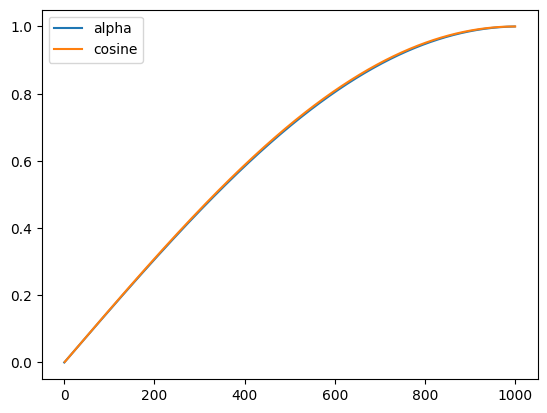

In [ ]:
plt.plot(sched.timesteps, sched.alphas_cumprod.sqrt())
plt.plot(1000-sched.timesteps, np.cos(sched.timesteps /1000 * math.pi/2))
plt.legend(['alpha', 'cosine'])

In [ ]:
sched.set_timesteps(500)

In [ ]:
learn.model.cuda();

In [ ]:
res = diff_sampler(learn.model,(1,3,128,128), sched)

In [ ]:
outp = torch.cat([TensorImage(o) for i,o in enumerate(res) if i%30==0])

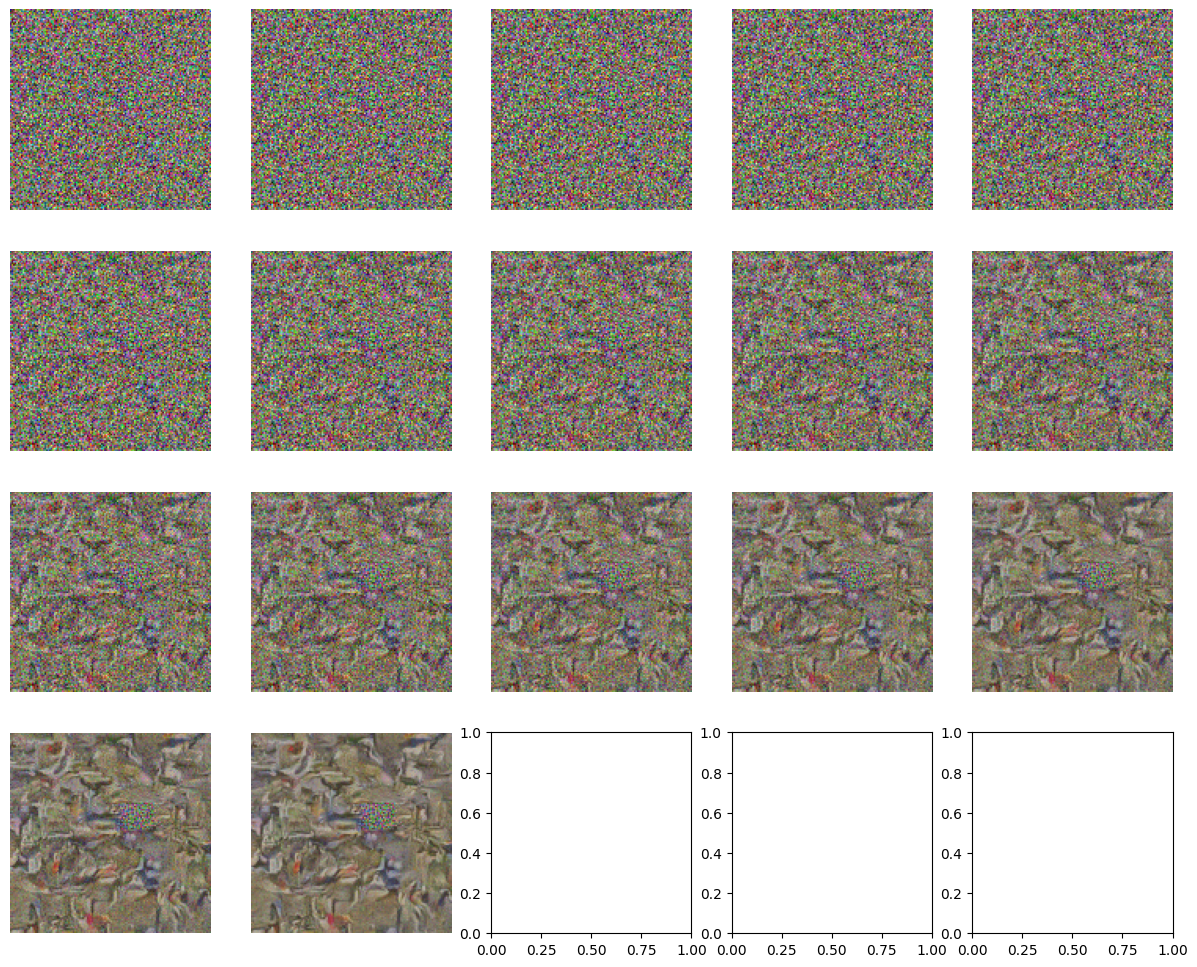

In [ ]:
show_images(dls.after_batch.decode(outp), nrows=4)

In [ ]:
res = torch.cat(res)

<matplotlib.legend.Legend>

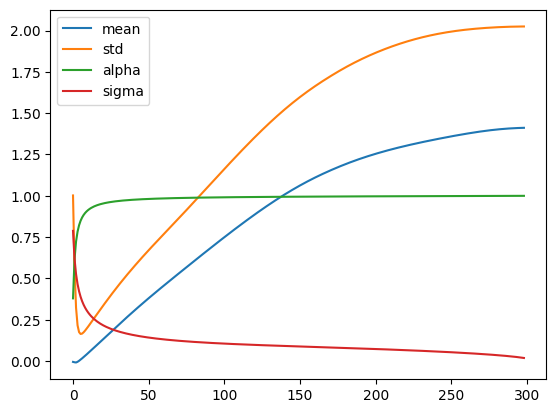

In [ ]:
plt.plot(sched.means)
plt.plot(sched.stds)
plt.plot(sched.alphas)
plt.plot(sched.sigmas)
plt.legend(['mean', 'std', 'alpha', 'sigma'])

In [ ]:
# TODO
def x0_loss(x_pred, t, x0):
    return F.mse_loss(x_pred, x0)

def eps_loss(eps_pred, t, eps):
    return F.mse_loss(eps_pred, eps)

def v_loss(v_pred, t, v):
    return F.mse_loss(v_pred, v)

In [ ]:
# Nested U-net